# AutoEncoder model 

### Loading the dataset

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import numpy as np

In [4]:
def multiple_plotting():
    # 파일 경로, 이름 설정해주세요.
    data1_df = pd.read_csv('data/normal_9v_data.csv', header=None)
    data2_df = pd.read_csv('data/normal_10v_data.csv', header=None)
    data3_df = pd.read_csv('data/normal_11v_data.csv', header=None)
    data4_df = pd.read_csv('data/normal_12v_data.csv', header=None)

    data1_df.columns = ['x', 'y', 'z']
    data2_df.columns = ['x', 'y', 'z']
    data3_df.columns = ['x', 'y', 'z']
    data4_df.columns = ['x', 'y', 'z']


    vector_value1 = np.sqrt(data1_df['x']** 2 + data1_df['y']**2 + data1_df['z']**2)
    vector_value2 = np.sqrt(data2_df['x']** 2 + data2_df['y']**2 + data2_df['z']**2)
    vector_value3 = np.sqrt(data3_df['x']** 2 + data3_df['y']**2 + data3_df['z']**2)
    vector_value4 = np.sqrt(data4_df['x']** 2 + data4_df['y']**2 + data4_df['z']**2)

    plt.figure(figsize=(20,20))
    fig, axes = plt.subplots(nrows=2, ncols=2)

    axes[0][0].plot(vector_value1)
    axes[0][1].plot(vector_value2)
    axes[1][0].plot(vector_value3)
    axes[1][1].plot(vector_value4)

    for ax in axes.flatten():
        ax.set_ylim(0.6, 1.4)
    plt.show()

<Figure size 2000x2000 with 0 Axes>

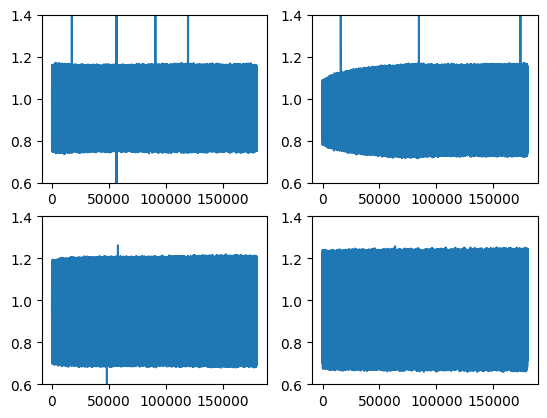

In [4]:
multiple_plotting()

In [5]:
data1_df = pd.read_csv('data/normal_9v_data.csv', header=None)
data2_df = pd.read_csv('data/normal_10v_data.csv', header=None)
data3_df = pd.read_csv('data/normal_11v_data.csv', header=None)
data4_df = pd.read_csv('data/normal_12v_data.csv', header=None)


print(data1_df.shape)
combined_df = pd.concat([data1_df, data2_df, data3_df, data4_df], ignore_index=True)
print(combined_df.shape)

(180000, 3)
(720558, 3)


In [25]:
train_ratio = 0.7
temp_ratio = 0.3  # for both val and test combined
val_ratio = 0.5  # 50% of temp_ratio for validation
test_ratio = temp_ratio / 2  # same as val_ratio

data4_df = data4_df[:len(data4_df) - (len(data4_df) % 100)]
# data4_df = data4_df[:-558]
print(len(data1_df), len(data2_df), len(data3_df), len(data4_df))

data_split_0 = np.array_split(data1_df, len(data1_df) // 100)
data_split_1 = np.array_split(data2_df, len(data2_df) // 100)
data_split_2 = np.array_split(data3_df, len(data3_df) // 100)
data_split_3 = np.array_split(data4_df, len(data4_df) // 100)

data_splits = [data_split_0, data_split_1, data_split_2, data_split_3]

train_sizes = []
train_data = []
val_data = []
test_data = []

for i in range(4):
    data_len = len(data_splits[i])
    train_size = int(data_len * train_ratio)
    temp_size = data_len - train_size 
    val_size = int(temp_size * val_ratio)
    
    # Split the data
    train_sizes.append(train_size)
    train_data.append(data_splits[i][:train_size])
    val_data.append(data_splits[i][train_size:train_size + val_size])
    test_data.append(data_splits[i][train_size + val_size:])

# check the lengths of each split
for i in range(4):
    print(f"Data split {i}: train + val + test =", len(train_data[i]), "+", len(val_data[i]), "+", len(test_data[i]))
    print(len(train_data[i][0]), len(val_data[i][0]),  len(test_data[i][0]))

# Concatenate all splits across the 4 data parts
x_train_concat = np.concatenate(train_data, axis=0)
x_val_concat = np.concatenate(val_data, axis=0)
x_test_concat = np.concatenate(test_data, axis=0)

# x_train_concat = pd.concat(train_data, ignore_index=True)
# x_val_concat = pd.concat(val_data, ignore_index=True)
# x_test_concat = pd.concat(test_data, ignore_index=True)

# Output final shapes to confirm correct splitting
print("Train data shape:", x_train_concat.shape)
print("Validation data shape:", x_val_concat.shape)
print("Test data shape:", x_test_concat.shape)



180000 180000 180000 178800
Data split 0: train + val + test = 1260 + 270 + 270
100 100 100
Data split 1: train + val + test = 1260 + 270 + 270
100 100 100
Data split 2: train + val + test = 1260 + 270 + 270
100 100 100
Data split 3: train + val + test = 1251 + 268 + 269
100 100 100
Train data shape: (5031, 100, 3)
Validation data shape: (1078, 100, 3)
Test data shape: (1079, 100, 3)


In [28]:
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D

# 데이터 예시
input_shape = (100, 3)  # 1D 데이터의 형태 (예: 1000개의 시간 포인트)

# 인코더
input_layer = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(pool_size=2, padding='same')(x)

# 디코더
x = UpSampling1D(size=2)(encoded)
x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)

x = UpSampling1D(size=2)(x)
decoded = Conv1D(3, kernel_size=3, activation='sigmoid', padding='same')(x)

# 모델 생성
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 모델 학습
autoencoder.fit(
    x_train_concat, 
    x_train_concat,
    epochs=20, 
    batch_size=32, 
    validation_data = (x_val_concat, x_val_concat),
    verbose = 1,
    shuffle=False
    # validation_split=0.2
    )




Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1041 - val_loss: 0.0043
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 9/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 10/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 11/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 12/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [29]:
autoencoder.save("autoencoder.h5")

In [ ]:
history = model.fit(
    x_train_concat, y_train_one_hot,  # Ensure y_train is one-hot encoded for multi-class
    epochs=20,
    batch_size=32,
    validation_data=(x_val_concat, y_valid_one_hot),
    verbose=1,
    # class_weight=class_weights_dict,
    callbacks=[early_stop]
)

# Save the model
model.save("u_net_v5.h5")